In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import pathlib
import random
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_addons as tfa
# !pip install ktrain
# import ktrain
# from ktrain.dataset import TFDataset
tf.test.is_gpu_available()

2022-04-26 00:12:34.801409: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-26 00:12:34.854422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 00:12:34.944050: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 00:12:34.944817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

True

Data investigation
==

How many training images? How many unique drivers? How many images per class?
--
Note that we will not see any of the same drivers in the competition test set as are in the training set. Therefore, our measure of model quality must include some drivers that have not been seen before.

In [2]:
# define path to training data and count number of images
data_dir1 = '../input/state-farm-distracted-driver-detection/imgs/train'
data_dir = pathlib.Path(data_dir1)

class_names = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
true_class_names = ['safe_drive', 'text_r', 'phone_r', 'text_l', 'phone_l', 'radio', 'drink', 'reach_bhd', 'hair_mkup', 'talk_passenger']
class_2_descriptor = {"c0": "safe_drive", "c1": "text_r", "c2": "phone_r", "c3": "text_l", "c4": "phone_l", "c5": "radio", "c6": "drink", "c7": "reach_bhd", "c8": "hair_mkup", "c9": "talk_passenger"}
class_2_int = {"c0": 0, "c1": 1, "c2": 2, "c3": 3, "c4": 4, "c5": 5, "c6": 6, "c7": 7, "c8": 8, "c9": 9}

# count number of images in the training set
image_count = len(list(data_dir.glob('*/*.jpg')))
print('There are', str(image_count), 'Images in the training set.')

There are 22424 Images in the training set.


In [3]:
# count number of unique drivers in the training set
img_list_path = '../input/state-farm-distracted-driver-detection/driver_imgs_list.csv'
driver_imgs_list = pd.read_csv(img_list_path)
assert len(driver_imgs_list) == image_count
unique_driver_IDs = np.unique(driver_imgs_list["subject"].to_numpy())
n_uniq_drivers = len(unique_driver_IDs)
print('There are', str(n_uniq_drivers), 'unique drivers in the training set.')

# check number of images of each driver
n_img_per_driver = []
for driver in unique_driver_IDs:
    n_img_per_driver.append(np.sum(driver_imgs_list["subject"].to_numpy() == driver))
    
print('No imgs per driver: ' + str(n_img_per_driver))
assert sum(n_img_per_driver) == image_count

There are 26 unique drivers in the training set.
No imgs per driver: [725, 823, 876, 875, 1078, 1237, 1233, 1226, 1196, 848, 651, 605, 591, 724, 835, 1011, 790, 920, 740, 794, 809, 820, 1034, 346, 814, 823]


In [ ]:
# plot an image of each driver
plt.figure(figsize=(20, 25))
for i in range(n_uniq_drivers):
    imgIDs = np.where(driver_imgs_list["subject"].to_numpy() == unique_driver_IDs[i])[0]
    imgID = random.randint(imgIDs[0], imgIDs[-1])
    classname = driver_imgs_list["classname"][imgID]
    img_name = driver_imgs_list["img"][imgID]
    img_path = data_dir1 + '/' + classname + '/' + img_name
    img = Image.open(img_path)
    ax = plt.subplot(int(np.round(n_uniq_drivers/3)), 3, i + 1)
    plt.imshow(img)
    plt.title('driver: ' + unique_driver_IDs[i] + ', ' + str(n_img_per_driver[i]) + ' images (' + class_2_descriptor[classname] + ')')
    plt.axis("off")

Generate more training data to address imbalances/overfitting - to do...
==
Ideas: 
- Ensure number of classes AND drivers are balanced
- Create some additional greyscale images which might avoid colour sensitivity

Splitting the training data
==
Take 10% as a test set - use all images of one driver and then random selection of other drivers
--

In [4]:
n_test_imgs = int(np.round(0.1*image_count))
print("No of test images = ", str(n_test_imgs))
# pick a random driver to be solely in the test set
test_driverID = random.randint(0, n_uniq_drivers-1)
# img IDs of random driver
test_img_IDs = np.where(driver_imgs_list["subject"].to_numpy() == unique_driver_IDs[test_driverID])[0]
n_single_driver_imgs = len(test_img_IDs)

# fill up the remainder of the test set with randomly selected imgs
n_imgs_2_add = n_test_imgs - len(test_img_IDs)
all_img_IDs = np.arange(0, image_count)
remaining_img_IDs = np.delete(all_img_IDs, test_img_IDs)
test_img_IDs = np.sort(np.append(test_img_IDs, random.sample(list(remaining_img_IDs), n_imgs_2_add)))
assert len(test_img_IDs) == n_test_imgs
print('Test image set contains', str(n_single_driver_imgs), 'images of single driver', str(unique_driver_IDs[test_driverID]))

No of test images =  2242
Test image set contains 809 images of single driver p061


Take 20% as a cross-validation set - should contain at least two unseen drivers
--
Potentially do K-folds on this

In [5]:
n_CV_imgs = int(np.round(0.2*image_count))
print("No of cross-val images = ", str(n_CV_imgs))
# pick two random drivers to be solely in the test set
CV_driverID = random.randint(0, n_uniq_drivers-1)
while CV_driverID == test_driverID:
    CV_driverID = random.randint(0, n_uniq_drivers-1)
# img IDs of random driver
CV_img_IDs = np.where(driver_imgs_list["subject"].to_numpy() == unique_driver_IDs[CV_driverID])[0]
n_single_driver_imgs = len(CV_img_IDs)

# fill up the remainder of the test set with randomly selected imgs
n_imgs_2_add = n_CV_imgs - len(CV_img_IDs)
remaining_img_IDs = np.delete(all_img_IDs, np.append(test_img_IDs, CV_img_IDs))
CV_img_IDs = np.sort(np.append(CV_img_IDs, random.sample(list(remaining_img_IDs), n_imgs_2_add)))
assert len(CV_img_IDs) == n_CV_imgs
print('Cross-val image set contains', str(n_single_driver_imgs), 'images of single driver', str(unique_driver_IDs[CV_driverID]))

No of cross-val images =  4485
Cross-val image set contains 848 images of single driver p035


In [6]:
# remaining IDs = train IDs
train_img_IDs = np.delete(all_img_IDs, np.append(test_img_IDs, CV_img_IDs))
print('No of training images =', str(len(train_img_IDs)))

No of training images = 15755


Create datasets
==
Declare function for assembling datasets
--
This is basically a copy of some of the functionality within tf.keras.utils.image_dataset_from_directory, but modified so I can pass my own lists of img directories/labels

In [7]:
from keras.preprocessing.image_dataset import paths_and_labels_to_dataset
def img_dataset_from_filePaths(img_paths, labels, class_names, batch_size, seed, img_height, img_width, label_mode='int'):
    rng = np.random.RandomState(seed)
    rng.shuffle(img_paths)
    rng = np.random.RandomState(seed)
    rng.shuffle(labels)
    dataset = paths_and_labels_to_dataset(img_paths,
                                          image_size=(img_height, img_width),
                                          num_channels=3,
                                          labels=labels,
                                          label_mode=label_mode,
                                          num_classes=len(class_names),
                                          interpolation='bilinear',
                                          crop_to_aspect_ratio=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    # Shuffle locally at each iteration
    dataset = dataset.shuffle(buffer_size=batch_size * 8, seed=seed)
    dataset = dataset.batch(batch_size)

    dataset.class_names = class_names
    dataset.file_paths = img_paths
    return dataset

def paths_labels_from_IDs(img_IDs, driver_imgs_list, class_2_int):
    img_paths = []
    labels = []
    for imgID in img_IDs:
        classname = driver_imgs_list["classname"][imgID]
        img_name = driver_imgs_list["img"][imgID]
        img_paths.append(data_dir1 + '/' + classname + '/' + img_name)
        labels.append(class_2_int[classname])
    return img_paths, labels

Assemble training, cross-validation, and testing datasets
--

In [8]:
# general options for datasets
batch_size = 56
img_width = 200
img_height = int(img_width/640*480)
image_size = (img_height, img_width)

# load paths and labels for train images
img_paths, labels = paths_labels_from_IDs(train_img_IDs, driver_imgs_list, class_2_int)
# generate training dataset
train_ds = img_dataset_from_filePaths(img_paths, labels, true_class_names, batch_size, 123, img_height, img_width, label_mode='int')
# train_ds = TFDataset(train_ds, len(train_img_IDs), labels)

# load paths and labels for cross-val images
img_paths, labels = paths_labels_from_IDs(CV_img_IDs, driver_imgs_list, class_2_int)
# generate cross-val dataset
CV_ds = img_dataset_from_filePaths(img_paths, labels, true_class_names, batch_size, 123, img_height, img_width, label_mode='int')
# CV_ds = TFDataset(CV_ds, len(CV_img_IDs), labels)

# load paths and labels for test images
img_paths, labels = paths_labels_from_IDs(test_img_IDs, driver_imgs_list, class_2_int)
# generate test dataset
test_ds = img_dataset_from_filePaths(img_paths, labels, true_class_names, batch_size, 123, img_height, img_width, label_mode='int')
# test_ds = TFDataset(test_ds, len(test_img_IDs), labels)

2022-04-26 00:13:05.970630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 00:13:05.971556: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 00:13:05.972196: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 00:13:05.973179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 00:13:05.973857: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [ ]:
plt.figure(figsize=(25, 25))
for images, labels in train_ds.take(3):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

Define data augmentation layers
==

In [9]:
img_augmentation = Sequential(
    [
#         layers.RandomTranslation(height_factor=0.1, width_factor=(0,0.1), input_shape=(img_height, img_width, 3)),
#         layers.RandomFlip("horizontal"),
#         layers.RandomRotation(factor=0.1),
        layers.RandomZoom(height_factor=(-0.2, 0)),
#         layers.RandomContrast(factor=(0.5)),
    ],
    name="img_augmentation",
)

In [ ]:
# view augmented images
plt.figure(figsize=(25, 25))
for image, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image[0], axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Speed up data loading with cache and prefetch
==

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
CV_ds = CV_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Build simple CNN model without augmentation (turns out it's not that helpful for the CV score...)
=

In [11]:
num_classes = len(class_names)
def get_model(num_classes, optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0, nesterov=False, name='SGD')):
    model = Sequential([

#         img_augmentation,
        layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

        layers.Conv2D(16, 3, padding='same'),
    #     layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(32, 3, padding='same'),
    #     layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, padding='same'),
    #     layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
#         layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    # optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['sparse_categorical_accuracy'])
    return model
# model = get_model(num_classes, lr = 0.001)
# model.summary()


# learner = ktrain.get_learner(model, train_data=train_ds, val_data = CV_ds)

Train basic model with Adam optimizer
==

In [ ]:
optimizer = tf.keras.optimizers.Adam()
model = get_model(num_classes, optimizer=optimizer)

epochs=20
history = model.fit(
    train_ds,
    validation_data=CV_ds,
    epochs=epochs
)

In [ ]:
# plot accuracy and loss history
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim((0.1,1))
plt.grid(True)
plt.xlabel("Epochs (-)")
plt.ylabel("Accuracy (-)")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim((0,2))
plt.grid(True)
plt.xlabel("Epochs (-)")
plt.ylabel("Loss (-)")
plt.title('Training and Validation Loss')
plt.show()

Train basic model with SGD
==
Find cyclical learning rate bounds
---

In [12]:
lr_bounds = [-8, 1]
n_epochs = 5
n_batches_per_epoch = int(np.ceil(len(train_img_IDs) / batch_size))
n_batches = n_epochs * n_batches_per_epoch
print('No of batches per epoch =', str(n_batches_per_epoch), 'and no of total batches =', str(n_batches))

# define learning rate finder callback
class LR_finder_callback(keras.callbacks.Callback):
    
    def __init__(self, lr_bounds, n_batches, n_epochs):
        super(LR_finder_callback, self).__init__()
        self.lr_bounds = lr_bounds
        self.n_batches = n_batches
        self.lr_list = np.logspace(lr_bounds[0], lr_bounds[1], n_batches+1)
        self.batch_num = 0
        self.avg_loss = 0
        self.beta = 0.98
        self.best_loss = 1e9
        self.loss_hist = []
        
    def on_train_begin(self, logs=None):
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr_list[0])
        
    def on_train_batch_end(self, batch, logs=None):
        self.batch_num += 1
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        
        loss = logs.get("loss")
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.batch_num)
        
        # save current lr, loss and smoothed loss 
        self.loss_hist.append([lr, loss, smoothed_loss])
        
        if self.batch_num > 1 and smoothed_loss > 4 * self.best_loss:
            self.model.stop_training = True
            return
        if smoothed_loss < self.best_loss or self.batch_num == 1:
            self.best_loss = smoothed_loss
        
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr_list[self.batch_num])
        
    def on_train_end(self, logs=None):
        self.loss_hist = np.stack(self.loss_hist)
        self.model.lr_finder = self


No of batches per epoch = 282 and no of total batches = 1410


Epoch 1/5


2022-04-26 00:13:32.337102: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-26 00:13:35.203384: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


282/282 [==============================] - 87s 277ms/step - loss: 2.3044 - sparse_categorical_accuracy: 0.1060 - val_loss: 2.3048 - val_sparse_categorical_accuracy: 0.1086
Epoch 2/5
282/282 [==============================] - 6s 22ms/step - loss: 2.3044 - sparse_categorical_accuracy: 0.1061 - val_loss: 2.3045 - val_sparse_categorical_accuracy: 0.1088
Epoch 3/5
282/282 [==============================] - 6s 21ms/step - loss: 2.3016 - sparse_categorical_accuracy: 0.1177 - val_loss: 2.2938 - val_sparse_categorical_accuracy: 0.1418
Epoch 4/5
282/282 [==============================] - 6s 21ms/step - loss: 2.2312 - sparse_categorical_accuracy: 0.1952 - val_loss: 2.2740 - val_sparse_categorical_accuracy: 0.2120
Epoch 5/5
282/282 [==============================] - 6s 23ms/step - loss: 2.3086 - sparse_categorical_accuracy: 0.1137 - val_loss: 2.4935 - val_sparse_categorical_accuracy: 0.0961


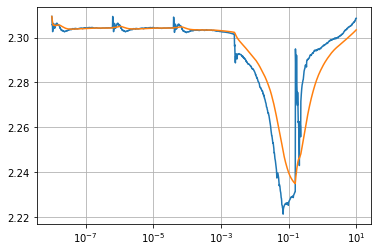

In [13]:
model_LRfind = get_model(num_classes)
history_LRfind = model_LRfind.fit(
    train_ds,
    validation_data=CV_ds,
    callbacks=[LR_finder_callback(lr_bounds, n_batches, n_epochs)],
    epochs=n_epochs)
loss_hist = model_LRfind.lr_finder.loss_hist
plt.semilogx(loss_hist[:,0], loss_hist[:,1])
plt.semilogx(loss_hist[:,0], loss_hist[:,2])
# plt.ylim((2.2,2.8))
plt.grid(True)
plt.show()

Train model with SGD optimizer with triangle cyclic learning rate scheduling
--

In [15]:
# define triangle lr scheduling
INIT_LR = 1e-3
MAX_LR = 7e-2
steps_per_epoch = len(train_img_IDs) // batch_size
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: x,
    step_size=2 * steps_per_epoch
)
optimizer = tf.keras.optimizers.SGD(clr)
modelSGD = get_model(num_classes, optimizer=optimizer)

epochs=20
historySGD = modelSGD.fit(
    train_ds,
    validation_data=CV_ds,
    epochs=epochs
)

Epoch 1/20
282/282 [==============================] - 6s 21ms/step - loss: 2.1944 - sparse_categorical_accuracy: 0.2060 - val_loss: 2.2697 - val_sparse_categorical_accuracy: 0.2198
Epoch 2/20
282/282 [==============================] - 6s 20ms/step - loss: 2.1007 - sparse_categorical_accuracy: 0.2155 - val_loss: 2.3015 - val_sparse_categorical_accuracy: 0.1095
Epoch 3/20
282/282 [==============================] - 6s 21ms/step - loss: 2.3024 - sparse_categorical_accuracy: 0.1095 - val_loss: 2.3004 - val_sparse_categorical_accuracy: 0.1095
Epoch 4/20
282/282 [==============================] - 6s 20ms/step - loss: 2.3009 - sparse_categorical_accuracy: 0.1118 - val_loss: 2.2992 - val_sparse_categorical_accuracy: 0.1095
Epoch 5/20
282/282 [==============================] - 6s 20ms/step - loss: 2.3000 - sparse_categorical_accuracy: 0.1119 - val_loss: 2.2992 - val_sparse_categorical_accuracy: 0.1095
Epoch 6/20
282/282 [==============================] - 6s 20ms/step - loss: 2.3003 - sparse_cate

In [ ]:
# plot accuracy and loss history
acc = historySGD.history['sparse_categorical_accuracy']
val_acc = historySGD.history['val_sparse_categorical_accuracy']
loss = historySGD.history['loss']
val_loss = historySGD.history['val_loss']

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim((0.1,1))
plt.grid(True)
plt.xlabel("Epochs (-)")
plt.ylabel("Accuracy (-)")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim((0,2))
plt.grid(True)
plt.xlabel("Epochs (-)")
plt.ylabel("Loss (-)")
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
modelSGD.evaluate(x=CV_ds)
modelSGD.evaluate(x=test_ds)
# model.evaluate(x=train_ds)

Try same simple model but with some regularisation
==
Redeclare model
--

In [16]:
def get_model_reg(num_classes, optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0, nesterov=False, name='SGD')):
    model = Sequential([

#         img_augmentation,
        layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

        layers.Conv2D(32, 3, padding='same'),
    #     layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.5),

        layers.Conv2D(64, 3, padding='same'),
    #     layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.5),

        layers.Conv2D(128, 3, padding='same'),
    #     layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.5),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    # optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['sparse_categorical_accuracy'])
    return model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 150, 200, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 150, 200, 32)      896       
_________________________________________________________________
activation_9 (Activation)    (None, 150, 200, 32)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 75, 100, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 100, 32)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 75, 100, 64)       18496     
_________________________________________________________________
activation_10 (Activation)   (None, 75, 100, 64)      

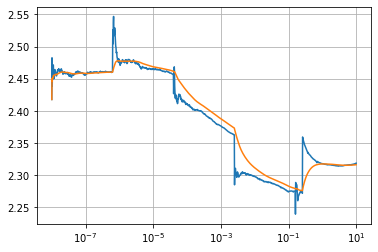

In [17]:
model_LRfind = get_model_reg(num_classes)
model_LRfind.summary()
history_LRfind = model_LRfind.fit(
    train_ds,
    validation_data=CV_ds,
    callbacks=[LR_finder_callback(lr_bounds, n_batches, n_epochs)],
    epochs=n_epochs)
loss_hist = model_LRfind.lr_finder.loss_hist
plt.semilogx(loss_hist[:,0], loss_hist[:,1])
plt.semilogx(loss_hist[:,0], loss_hist[:,2])
# plt.ylim((2.2,2.8))
plt.grid(True)
plt.show()

In [18]:
# define triangle lr scheduling
steps_per_epoch = len(train_img_IDs) // batch_size
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-5,
    maximal_learning_rate=1e-2,
#     scale_fn=lambda x: 3/(4.**(x-1)),
    scale_fn=lambda x: x,
    step_size=2 * steps_per_epoch)
optimizer = tf.keras.optimizers.SGD(clr)

model_reg = get_model_reg(num_classes, optimizer=optimizer)

epochs=60
history_reg = model_reg.fit(
    train_ds,
    validation_data=CV_ds,
    epochs=epochs)

Epoch 1/60
282/282 [==============================] - 11s 37ms/step - loss: 2.3394 - sparse_categorical_accuracy: 0.1203 - val_loss: 2.2838 - val_sparse_categorical_accuracy: 0.1677
Epoch 2/60
282/282 [==============================] - 10s 36ms/step - loss: 2.1967 - sparse_categorical_accuracy: 0.1900 - val_loss: 2.1709 - val_sparse_categorical_accuracy: 0.2890
Epoch 3/60
282/282 [==============================] - 10s 36ms/step - loss: 1.8960 - sparse_categorical_accuracy: 0.3030 - val_loss: 1.8209 - val_sparse_categorical_accuracy: 0.4997
Epoch 4/60
282/282 [==============================] - 10s 37ms/step - loss: 1.6669 - sparse_categorical_accuracy: 0.3956 - val_loss: 1.6806 - val_sparse_categorical_accuracy: 0.5837
Epoch 5/60
282/282 [==============================] - 10s 36ms/step - loss: 1.6273 - sparse_categorical_accuracy: 0.4095 - val_loss: 1.7457 - val_sparse_categorical_accuracy: 0.3951
Epoch 6/60
282/282 [==============================] - 10s 37ms/step - loss: 1.5416 - spars

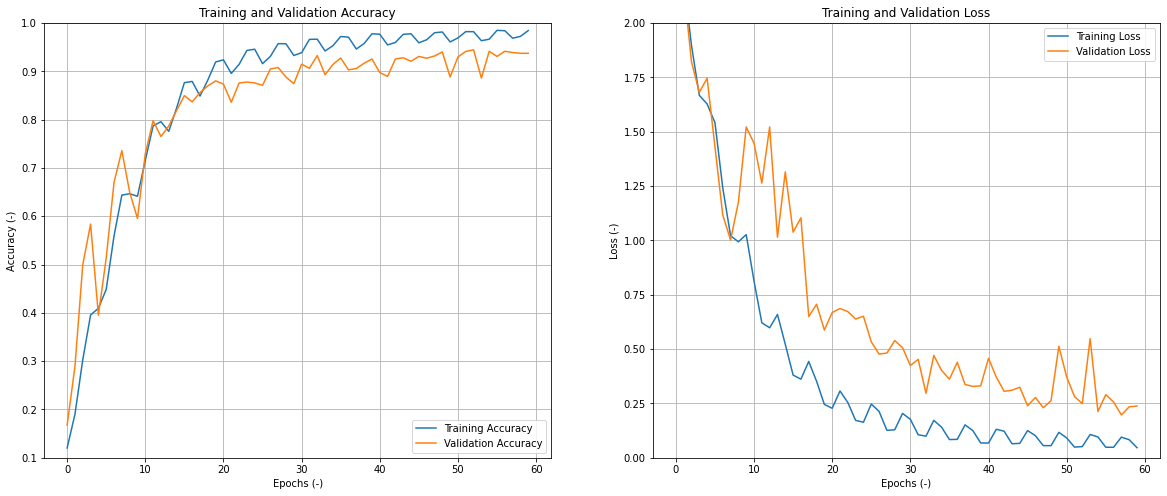

In [20]:
# plot accuracy and loss history
acc = history_reg.history['sparse_categorical_accuracy']
val_acc = history_reg.history['val_sparse_categorical_accuracy']
loss = history_reg.history['loss']
val_loss = history_reg.history['val_loss']

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim((0.1,1))
plt.grid(True)
plt.xlabel("Epochs (-)")
plt.ylabel("Accuracy (-)")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim((0.0,2))
plt.grid(True)
plt.xlabel("Epochs (-)")
plt.ylabel("Loss (-)")
plt.title('Training and Validation Loss')
plt.show()

In [19]:
model_reg.evaluate(x=CV_ds)
model_reg.evaluate(x=test_ds)

41/41 [==============================] - 9s 172ms/step - loss: 0.3986 - sparse_categorical_accuracy: 0.8622


[0.39856746792793274, 0.8621766567230225]

Analyse results
=

In [ ]:
# plot accuracy and loss history
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim((0.1,1))
plt.grid(True)
plt.xlabel("Epochs (-)")
plt.ylabel("Accuracy (-)")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim((0.25,2))
plt.grid(True)
plt.xlabel("Epochs (-)")
plt.ylabel("Loss (-)")
plt.title('Training and Validation Loss')
plt.show()

In [22]:
# Check log loss equation
p = model_reg.predict(CV_ds)
labels = np.concatenate([y for x, y in CV_ds], axis=0)
y = tf.one_hot(labels, 10)
p = p / np.sum(p, axis=1, keepdims=True)
p[p > 1-1E-15] = 1-1E-15
p[p < 1e-15] = 1e-15

log_loss = - np.sum(y * np.log(p))/p.shape[0]
print(log_loss)


0.23794165773933945


tf.Tensor(
[[459   0   0   1   0   1   2  17   4   7]
 [  0 429   0   0   0   0  17   2   1   0]
 [  0   0 447   0   0   0   1   0  45   0]
 [  2   0   0 476   0   0   1   2   2   0]
 [  0   0   0   1 444   0   0   3   0   0]
 [  0   0   0   0   1 477   0   0   1   0]
 [  0   0  22   0   0   1 371  50  10   0]
 [  0   0   1   0   1   0   0 394   0   0]
 [  0   1   1   0   0   0   2   0 354   3]
 [  2   0   4   1   0   0   0  59  13 352]], shape=(10, 10), dtype=int32)


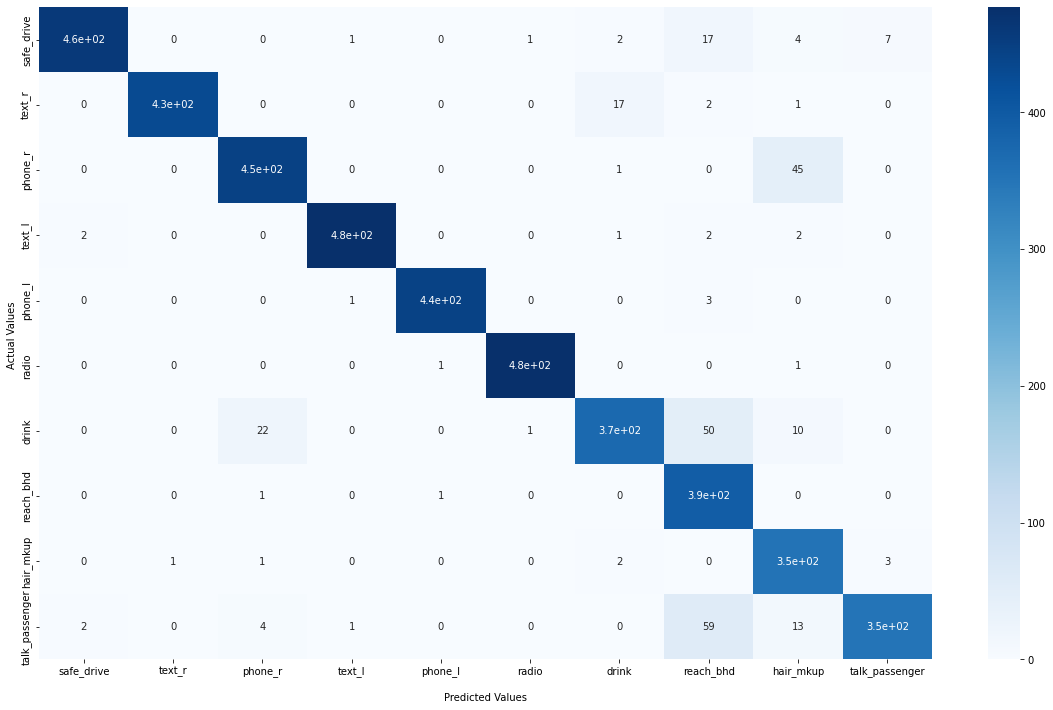

In [23]:
# plot confusion matrix
predictions = np.argmax(model_reg.predict(CV_ds), axis=1)
labels = np.concatenate([y for x, y in CV_ds], axis=0)
confusMatrx = tf.math.confusion_matrix(labels, predictions)
print(confusMatrx)

import seaborn as sns
plt.figure(figsize=(20, 12))
# ax = sns.heatmap(10*confusMatrx/np.sum(confusMatrx), annot=True, cmap='Blues')
ax = sns.heatmap(confusMatrx, annot=True, cmap='Blues')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['safe_drive', 'text_r', 'phone_r', 'text_l', 'phone_l', 'radio', 'drink', 'reach_bhd', 'hair_mkup', 'talk_passenger'])
ax.yaxis.set_ticklabels(['safe_drive', 'text_r', 'phone_r', 'text_l', 'phone_l', 'radio', 'drink', 'reach_bhd', 'hair_mkup', 'talk_passenger'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
# save model
model.save('simple_CNN_v1.h5')

In [ ]:
def CosineAnnealingLR_with_Restart(epoch, lr):
    lr_min = 10e-5
    lr_max = 10e-2
    Te = 4
    Tmult = 1.5
    
    div = np.arange(0,epoch)/Te
    mult = np.sum(np.unique(Te*Tmult**(np.floor(div))))
    print(epoch, epoch/Te, Te*Tmult**(np.floor(epoch/Te)), mult)
    if epoch==0:
        mult=Te
    
    lr = lr_min + (lr_max - lr_min) * (1 + np.cos(np.pi * epoch / mult)) / 2 
    
    return lr

lr = 10e-2
lr_save = []
for epoch in range(20):
    lr = CosineAnnealingLR_with_Restart(epoch, lr)
    lr_save.append(lr)
print(lr_save)
    
callback = tf.keras.callbacks.LearningRateScheduler(CosineAnnealingLR_with_Restart)

Generating test set report
=========

In [ ]:
# load trained model
import tensorflow as tf
from tensorflow import keras
model = tf.keras.models.load_model('simple_CNN.h5')

In [24]:
# check number of test images
import fnmatch
import os

test_directory = '../input/state-farm-distracted-driver-detection/imgs/test'
test_img_names = fnmatch.filter(os.listdir(test_directory), '*.jpg')
print(test_img_names[0:10])
n_test_images = len(test_img_names)
print(n_test_images)
img_paths = []
for img in test_img_names:
    img_paths.append(test_directory + '/' + img)
print(img_paths[0:10])

['img_96590.jpg', 'img_32366.jpg', 'img_99675.jpg', 'img_85937.jpg', 'img_73903.jpg', 'img_89410.jpg', 'img_70462.jpg', 'img_45622.jpg', 'img_55507.jpg', 'img_34204.jpg']
79726


In [31]:
test_dataset = paths_and_labels_to_dataset(img_paths,
                                      image_size=(img_height, img_width),
                                      num_channels=3,
                                      labels=[],
                                      label_mode=None,
                                      num_classes=[],
                                      interpolation='bilinear',
                                      crop_to_aspect_ratio=False)
test_dataset = test_dataset.batch(batch_size)

In [32]:
# make predictions on test dataset
predictions = model_reg.predict(test_dataset)

In [37]:
# export scores to csv through a pandas dataframe
import pandas as pd
df = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'], index=test_img_names)
df.to_csv('submit_result_v1.csv')

This image most likely belongs to reach_bhd with a 100.00 percent confidence.


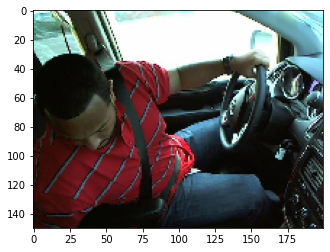

In [65]:
# check prediction for a single image
img_path = test_directory + '/' + test_img_names[np.random.randint(0,len(test_img_names))]
img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

score = model_reg.predict(img_array)
# score = tf.nn.softmax(prediction[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_2_descriptor[class_names[np.argmax(score)]], 100 * np.max(score)))
plt.imshow(np.squeeze(img))
plt.show()